# Welcome to the RegionDefiner Notebook!

**RegionDefiner** is a specialized conversational agent engineered to perform specialized regionalization tasks. It emphasizes the application of regionalization algorithms from PySAL spopt. The RegionDefiner assists in delineating regions, leveraging specific attributes and thresholds to enhance the understanding of spatial patterns and optimize regional planning efforts.

## Notebook Outline

### Setup of RegionDefiner: Spatial Data Input and Document Upload
- **Sanity Check Session**: Verifying local data loading and functionality of spopt functions.

### Interface Functions in RegionDefiner
- **Sanity Check Session**: Testing the custom wrapper functions designed for RegionDefiner.

### Overview of RegionDefiner
- A detailed look at the conversational agent powered by OpenAI, tailored for regional analysis.

### Practical Demonstrations
- **Case Study 1**: Evaluating responsiveness to educational content.
- **Case Study 2**: Regionalization tasks using data from Mexico.
- **Case Study 3**: Solving a Max-P problem with local datasets.
- **Case Study 4**: Domain identification queries within RegionDefiner.


## Setup of RegionDefiner: Spatial Data Input and Document Upload

**Model Flexibility**
- Users have the flexibility to switch between different underlying models, such as **GPT-3.5 turbo**, **GPT-4 turbo**, and **GPT-4o**, to test and compare performance. Default model is GPT-4 turbo.

**Data Integration**
- **Spatial Data Input**: Users should upload their own spatial data files for detailed analysis. The RegionDefiner supports shapefile format. **To facilitate analysis, shapefiles should be placed in the `data` folder within the current working directory.**

**File Search**
- **Document Upload:** **Users should upload our given regionalization documents into the `documents` folder under the current working directory to achieve document retrieval.** The documents we provided include "max_p_region_algorithm.docx," "p_regions_problem.docx," "max_p.docx," "skater_algorithm.docx," "azp_algorithm.docx," and "spenc_algorithm.docx". Uploading these documents into the `documents` folder allows the RegionDefiner to effectively utilize the File Search feature of the OpenAI Assistant when addressing user inquiries.

**Interactive Usage Example**
- Users can interact with the RegionDefiner by writing queries in the `user_message` parameter. Here is an example command to start a conversation:

```python
conversations(
    user_message="I would like to explicitly design zonal objects as meaningful entities related to a certain goal. Specifically, I’d like to decide which kind of aerial objects would be most useful for studying housing characteristics or unemployment rates.", 
    manager=manager, 
    verbose=VERBOSE)
```

**Future Developments**
- In the future, we plan to develop a user interface to streamline interactions, allowing users to engage with the RegionDefiner without running this notebook. This notebook currently serves as an illustration to demonstrate how the RegionDefiner operates and to facilitate initial testing and development.

For more information on the algorithms used, visit the [spopt repository on GitHub](https://github.com/pysal/spopt).



In [1]:
# Package Installation
# Below are the commands to install all necessary packages for this notebook. Run these cells to ensure you have the latest versions of the required libraries.

In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install inequality

In [ ]:
!pip install -U spopt

In [ ]:
!pip install geopandas

In [ ]:
!pip install openai

In [ ]:
!pip install matplotlib

In [ ]:
!pip install python-dotenv

In [9]:
# Load essential libraries
import os
import json
import datetime
import time
import numpy as np
import pandas as pd
import shutil
import geopandas
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import warnings

# Import OpenAI library
from openai import OpenAI

# Import spatial analysis libraries
import libpysal
from spopt.region import MaxPHeuristic as MaxP, RegionKMeansHeuristic, RandomRegion, RandomRegions, Skater, AZP, WardSpatial, Spenc

# Import inequality analysis tools
import inequality

# Constants
RANDOM_SEED = 12345

# Underlying GPT Model (either GPT-3.5-turbo, GPT-4-turbo, or GPT-4o is accepted)
MODEL = "gpt-4-turbo-preview"
#MODEL = "gpt-4o"
#MODEL = "gpt-3.5-turbo-1106"

# Configure settings
warnings.filterwarnings('ignore')
load_dotenv()  # Load environment variables from a .env file


False

In [10]:
# provide your OpenAI Key 
OPENAI_API_KEY = 

In [11]:
class EmptyAttributeNameError(Exception):
    def __init__(self, numeric_attrs):
        message = f"Attribute name is empty. It should belong to {numeric_attrs}"
        super().__init__(message)

class EmptyThresholdNameError(Exception):
    def __init__(self, attrs_name):
        message = f"Threshold name is empty. It should belong to {attrs_name}"
        super().__init__(message)

class NonNumericAttributeError(Exception):
    def __init__(self, not_numeric_attrs, numeric_attrs):
        message = f"The following attributes are not of numeric data type: {', '.join(not_numeric_attrs)}. It should belong to {numeric_attrs}"
        super().__init__(message)

class InvalidThresholdNameError(Exception):
    def __init__(self, threshold_name, attrs_name):
        message = f"{threshold_name} is not from {attrs_name}."
        super().__init__(message)

class ShapefileLoadingError(Exception):
    """Exception raised when a shapefile cannot be loaded."""
    def __init__(self, message="Failed to load the shapefile"):
        self.message = message
        super().__init__(self.message)

In [12]:
class ShapefileLoadingError(Exception):
    pass

def load_shapefile(input_file_path):
    """
    Load a shapefile into a GeoPandas DataFrame.
    
    Parameters:
    - input_file_path: str, the path to the shapefile, either as a libpysal example or a local file path.
    
    Returns:
    - gdf: GeoPandas DataFrame containing the shapefile data.
    """
    try:
        # Attempt to load from libpysal examples
        pth = libpysal.examples.get_path(input_file_path)
        if pth is None or not os.path.exists(pth):
            raise KeyError(f"{input_file_path} not found in libpysal examples.")
    except KeyError:
        # If not found, use the provided local path
        print("Shapefile not found in libpysal examples. Attempting to read from a local path.")
        pth = input_file_path

    try:
        # Load the shapefile into a GeoPandas DataFrame
        gdf = geopandas.read_file(pth)
        return gdf
    except Exception as e:
        #print(f"Failed to load the Shapefile: {e}")
        raise ShapefileLoadingError(f"Failed to load the Shapefile: {e}")


In [13]:
def region_labels(df, solution, name="labels_"):
    n, k = df.shape
    labels_ = np.zeros((n,), int)
    for i, region in enumerate(solution.regions):
        labels_[region] = i
    df[name] = labels_

In [14]:
def rename_shapefile(input_shapefile):
    # Ensure the input file has the correct .shp extension
    base_name, ext = os.path.splitext(input_shapefile)
    if ext.lower() != '.shp':
        raise ValueError("Input file must have a .shp extension")
    
    # Define the output shapefile name
    output_shapefile = f"{base_name}_output.shp"
    
    # Rename the .shp file
    return output_shapefile

In [15]:
def get_p_regions(n_cluster=5, attrs_name=["PCGDP1980"], input_file_path='mexicojoin.shp', algorithm='skater', plot_results=False):
    """
    Generate P regions from a given shapefile using the Skater algorithm.

    Args:
    - n_clusters (int): The desired number of contiguous regions to group spatial units into.
    - attrs_name (list of str): Attributes used to measure regional homogeneity, e.g., number of Airbnb spots.
    - input_file_path (str): Path to the input shapefile for loading into a GeoPandas DataFrame.
    - algoritm (str): The selected p-region algorithm, which should be one of the followings: 'skater', 'azp', 'kmeans', 'spenc', 'ward_spatial', 'random'.
    - plot_results (bool): If True, plot the resulting regions. Defaults to False.

    Returns:
    - gpd.GeoDataFrame: The GeoDataFrame with an additional column 'regions' indicating the region label for each spatial unit.

    This function loads spatial data from the specified shapefile, applies the Skater algorithm to form regions based on the specified attributes, and saves the resulting regions to a new shapefile.
    """

    # Load the shapefile into a GeoDataFrame
    gdf = load_shapefile(input_file_path)

    # Check if attrs_name is int or float datatype
    numeric_attrs = gdf.select_dtypes(include=['int', 'float']).columns
    if not attrs_name:
        raise EmptyAttributeNameError(numeric_attrs)

    not_numeric_attrs = [col for col in attrs_name if col not in numeric_attrs]
    if not_numeric_attrs:
        raise NonNumericAttributeError(not_numeric_attrs, numeric_attrs)
    
    # Initialize the Skater model with the given parameters
    if algorithm == 'random':
        random_regions = RandomRegion(
            area_ids=gdf.index.values.tolist(), 
            num_regions=n_cluster,
            contiguity=libpysal.weights.Queen.from_dataframe(gdf, use_index=False))
        region_labels(gdf, random_regions, name="regions")
    
    else:    
        if algorithm == 'skater':
            model = Skater(
                gdf=gdf,
                w=libpysal.weights.Queen.from_dataframe(gdf, use_index=False),
                attrs_name=attrs_name,
                n_clusters=n_cluster,
                floor=3,
                islands='ignore',
            )
        elif algorithm == 'azp':
            model = AZP(
                gdf=gdf,
                w=libpysal.weights.Queen.from_dataframe(gdf, use_index=False),
                attrs_name=attrs_name,
                n_clusters=n_cluster
            )
        elif algorithm == 'ward_spatial':
            model = WardSpatial(
                gdf=gdf,
                w=libpysal.weights.Queen.from_dataframe(gdf, use_index=False),
                attrs_name=attrs_name,
                n_clusters=n_cluster
            )
        elif algorithm == 'kmeans':        
            model = RegionKMeansHeuristic(
                data=gdf[attrs_name].values,
                w=libpysal.weights.Queen.from_dataframe(gdf, use_index=False),
                n_clusters=n_cluster
            )   
        elif algorithm == 'spenc':
            model = Spenc(
                gdf=gdf,
                w=libpysal.weights.Queen.from_dataframe(gdf, use_index=False),
                attrs_name=attrs_name,
                n_clusters=n_cluster
            )

        # Solve the model to generate regions
        model.solve()

        # Update the GeoDataFrame with the resulting regions
        gdf['regions'] = model.labels_
            
    # Save the updated GeoDataFrame to a new shapefile
    output_file_path = rename_shapefile(input_file_path)
    gdf.to_file(output_file_path)
    
    # Optionally, visualize the results
    if plot_results:
        ax = gdf.plot(
            figsize=(7, 14), column="regions", categorical=True, edgecolor="w"
        )
        ax.axis("off")
        fig = ax.get_figure()
        fig.savefig('plot_regions.jpeg', dpi=300)
    
    # Return the updated GeoDataFrame
    return gdf    

## Sanity Check Session: Testing Local Data Loading and spopt Functions

Before proceeding with detailed regional analyses, it is crucial to ensure that the system is correctly set up to load and process both local spatial data and the data provided with the Spopt package using Spopt functions. This sanity check session is designed to verify the integrity and functionality of the data loading processes and to test the performance of the Spopt algorithms with these datasets.

### Objectives:
- **Verify Local Data Loading:** Confirm that the shapefile data can be successfully loaded from the `data` folder under the current working directory to execute RegionDefine.
- **Test Data Loading from Spopt Package:** Ensure that RegionDefiner can also load and utilize the example datasets included with the Spopt package.
- **Test Spopt Functionality:** Execute basic Spopt functions to ensure they interact correctly with the loaded data and operate as expected, providing a robust test of system capabilities.

This session will help identify any issues early in the process, allowing for adjustments before moving on to more complex regionalization tasks. Ensuring that both local and package-provided data can be processed effectively is crucial for leveraging the full capabilities of the RegionDefiner.

**Please upload the necessary shapefiles, e.g., 'farms_us.shp', into the `data` folder in the current directory before running this script.**


In [17]:
## Sanity Check on Data and Spopt Functions

# Ensure the shapefile can be loaded correctly.
# Please upload the necessary shapefiles, e.g., 'farms_us.shp', into the "data" folder in the current directory before running this script.

gdf = load_shapefile('data/farms_us.shp')
gdf.head(1)

data/farms_us.shp is not a file in any installed dataset.
Shapefile not found in libpysal examples. Attempting to read from a local path.


,OBJECTID,CROP_HA,density,A_HA,geometry
0,24,4520.747306,0.007477,604590.955614,"POLYGON ((-705154.120 -583182.954, -705201.825..."


In [18]:
# check if the spopt data could loaded
gdf = load_shapefile('mexicojoin.shp')
gdf.head(1)

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,GR9000,LPCGDP40,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry
0,1,7.252751e+10,MX02,Baja California Norte,2040312.385,1.792187e+07,7252751.376,22361.0,20977.0,17865.0,...,0.05,4.35,4.32,4.25,4.4,4.47,4.43,4.48,1.0,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."


data/farms_us.shp is not a file in any installed dataset.
Shapefile not found in libpysal examples. Attempting to read from a local path.


,OBJECTID,CROP_HA,density,A_HA,geometry,regions
0,24,4520.747306,0.007477,604590.955614,"POLYGON ((-705154.120 -583182.954, -705201.825...",0


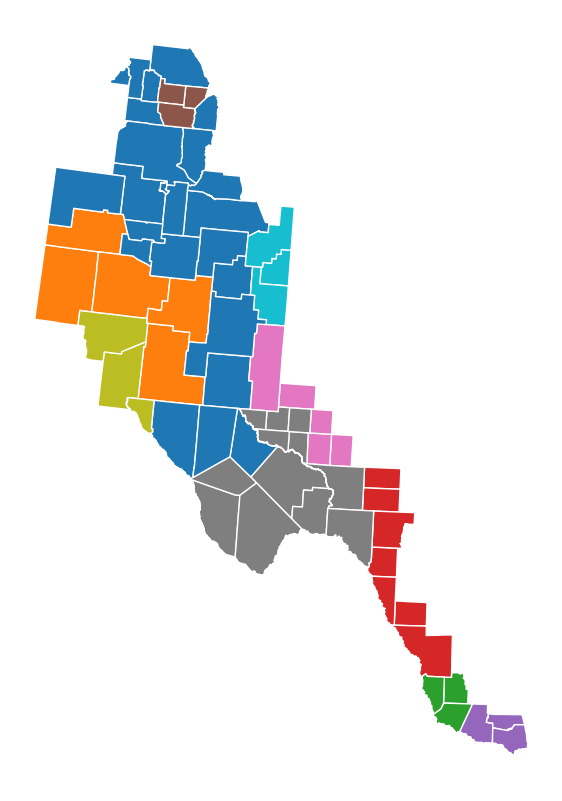

In [136]:
# skater
get_p_regions(
    n_cluster=10, 
    attrs_name=['density'], 
    #algorithm='azp',
    input_file_path='data/farms_us.shp', 
    plot_results=True
).head(1)

data/farms_us.shp is not a file in any installed dataset.
Shapefile not found in libpysal examples. Attempting to read from a local path.


,OBJECTID,CROP_HA,density,A_HA,geometry,regions
0,24,4520.747306,0.007477,604590.955614,"POLYGON ((-705154.120 -583182.954, -705201.825...",6.0


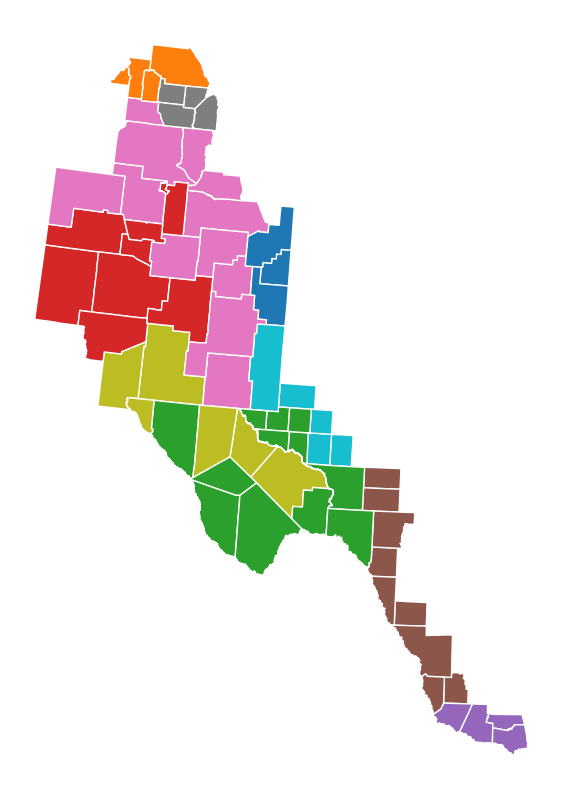

In [137]:
# azp
get_p_regions(
    n_cluster=10, 
    attrs_name=['density'], 
    algorithm='azp',
    input_file_path='data/farms_us.shp', 
    plot_results=True
).head(1)

## Wrapper Functions in RegionDefiner: Bridging Communication with Spopt Functions

The RegionDefiner employs specialized wrapper functions as a critical interface between the user and the underlying algorithms in PySAL spopt. These functions are designed to streamline the execution of spatial analysis tasks, providing clear feedback on the operation of these algorithms, their execution status, and any errors that occur.

### Purpose of Wrapper Functions:
- **Execution Management:** These functions initiate and manage the execution of regionalization algorithms, ensuring that each algorithm runs smoothly according to specified parameters.
- **Error Handling:** They are responsible for catching and interpreting errors during the execution of spopt functions. This allows immediate troubleshooting and provides understandable error messages that explain what went wrong.
- **Feedback Provision:** Wrapper functions deliver real-time feedback about the status of an algorithm's execution, including successful completions or detailed reports on any issues encountered.

These wrapper functions are fundamental to the operation of the RegionDefiner, enhancing its reliability and usability by ensuring that interactions with the Spopt algorithms are efficient, transparent, and user-centric.


In [47]:
def get_p_regions_response(n_clusters=5, attrs_name=["num_spots"], input_file_path='airbnb_Chicago 2015.shp', algorithm='skater', plot_results=False):
    """
    Wrapper function to call get_p_regions and handle any exceptions that arise, providing a user-friendly response.

    Args:
    - n_clusters (int): The desired number of contiguous regions to group spatial units into.
    - attrs_name (list of str): Attributes used to measure regional homogeneity, e.g., number of Airbnb spots.
    - input_file_path (str): Path to the input shapefile directory for loading into a GeoPandas DataFrame.
    - algoritm (str): The selected p-region algorithm, which should be one of the followings: 'skater', 'azp', 'kmeans', 'spenc', 'ward_spatial', 'random'.
    - plot_results (bool): If True, plot the resulting regions. Defaults to False.
    
    Returns:
    - str: A response message indicating the outcome of the regionalization process, or describing an error that occurred.
    """
    
    algorithm_list = ['skater', 'azp', 'kmeans', 'spenc', 'ward_spatial', 'random']
    if algorithm not in algorithm_list:
        response += f"Error: Please select an algorithm amongs {algorithm_list}."
        return response
    
    try:
        # Call the get_p_regions function and get the updated GeoDataFrame with region labels
        updated_gdf = get_p_regions(n_clusters, attrs_name, input_file_path, algorithm, plot_results)
        
        # Construct a response message indicating the successful regionalization
        response = f"The regionalization process was successful. The regions have been calculated and saved in 'region' column in '{rename_shapefile(input_file_path)}'."
        
        # You can also include additional information in the response, such as the number of unique regions
        unique_regions = updated_gdf['regions'].nunique()
        response += f" There are {unique_regions} unique regions now."
    except EmptyAttributeNameError as e:
        # Handle case where attribute name list is empty or None
        response = f"Error: {e}. Please provide a valid list of attribute names."
    except NonNumericAttributeError as e:
        # Handle case where some attributes are not numeric
        response = f"Error: {e}. All attributes must be numeric."
    except InvalidThresholdNameError as e:
        # Handle case where the threshold name is not valid
        response = f"Error: {e}. Ensure the threshold name is correct and included in the attribute names."
    except ShapefileLoadingError as e:
        # Handle errors related to loading the shapefile
        response = f"Error loading shapefile: {e}. Check the file path and ensure it points to a valid shapefile."
    except Exception as e:
        # Handle any other unexpected exceptions
        response = f"An unexpected error occurred: {e}."

    # Return the response message
    return response

In [48]:
def get_regionalization_maxp(threshold=5, attrs_name=None, threshold_name="count", input_file_path='mexicojoin.shp', top_n=2, plot_results=False):
    """
    Perform regionalization using the MaxP algorithm to group geographical units into regions based on specified attributes.

    Args:
    - threshold (int): Minimum cumulative value of the threshold attribute required for each region.
    - attrs_name (list of str, optional): List of attribute names used to evaluate homogeneity within regions. Defaults to None.
    - threshold_name (str): Name of the attribute to apply the threshold criterion. Defaults to "count".
    - input_file_path (str): Path to the shapefile with geographic data for regionalization. Defaults to 'mexicojoin.shp'.
    - top_n (int): Number of top solutions to consider in the regionalization algorithm. Defaults to 2.
    - plot_results (bool): If True, plot the resulting regions. Defaults to False.

    Returns:
    - int: Number of regions formed by the regionalization process.
    
    Raises:
    - EmptyAttributeNameError: If attrs_name is None or empty.
    - NonNumericAttributeError: If any attribute in attrs_name or threshold_name is not numeric.
    """
    
    # Load geographical data from the specified shapefile into a GeoDataFrame
    gdf = load_shapefile(input_file_path)

    # Initialize a dummy attribute to ensure the algorithm has data to process
    gdf['count'] = 1
    
    # Generate spatial weights based on Queen contiguity
    with warnings.catch_warnings(record=True):
        w = libpysal.weights.Queen.from_dataframe(gdf, use_index=False)
    
    # Validate attribute names and types for regionalization
    numeric_attrs = gdf.select_dtypes(include=['int', 'float']).columns
    if not attrs_name:
        raise EmptyAttributeNameError(numeric_attrs)
    if threshold_name is None:
        raise EmptyThresholdNameError(attrs_name)

    # Check for non-numeric attributes in attrs_name and raise an error if found
    not_numeric_attrs = [col for col in attrs_name if col not in numeric_attrs]
    if not_numeric_attrs:
        raise NonNumericAttributeError(not_numeric_attrs, numeric_attrs)
    if threshold_name not in numeric_attrs:
        raise NonNumericAttributeError(threshold_name, numeric_attrs)

    # Execute the MaxP algorithm with specified parameters
    np.random.seed(RANDOM_SEED)
    model = MaxP(gdf, w, attrs_name, threshold_name, threshold, top_n)
    model.solve()

    # Assign region labels to each geographical unit in the GeoDataFrame
    gdf['regions'] = model.labels_
            
    # Save the updated GeoDataFrame to a new shapefile
    output_file_path = rename_shapefile(input_file_path)
    gdf.to_file(output_file_path)
    
    # Optionally, plot the results
    if plot_results:
        gdf.plot(figsize=(8, 5), column="regions", cmap="tab20", edgecolor="w").axis("off");

    return model.p # Return the number of regions generated

In [49]:
def get_maxp_response(threshold=5, attrs_name=None, threshold_name="count", input_file_path='mexicojoin.shp', top_n=2, plot_results=False):
    """
    Wrapper function to call get_regionalization_maxp and handle any exceptions that arise, providing a user-friendly response.

    Args:
    - threshold (int): The minimum total value for the threshold attribute that each region must achieve. Used in regionalization to ensure regions meet a certain criterion.
    - attrs_name (list of str, optional): Names of the attributes used for measuring regional homogeneity. These attributes are considered in the regionalization process to ensure regions are similar internally.
    - threshold_name (str): The name of the attribute used as a threshold criterion for forming regions. This attribute must meet or exceed the 'threshold' value in each region.
    - input_file_path (str): The path to the input shapefile containing the geographical data for regionalization. This file is used to load geographic data into a GeoDataFrame.
    - top_n (int): The number of top regions to consider in the regionalization process. This parameter can be used to limit the analysis to a certain number of top regions based on specific criteria.
    - plot_results (bool): If True, plot the resulting regions. Defaults to False.

    Returns:
    - str: A response message indicating the outcome of the regionalization process. This message will either indicate success and the number of regions created or describe an error that occurred.
    """
    
    try:
        # Attempt to call the function that may raise custom exceptions
        n_regions = get_regionalization_maxp(threshold, attrs_name, threshold_name, input_file_path, top_n, plot_results)
        response = f"The regionalization process was successful, resulting in {n_regions} regions. The original geopandas dataframe is updated and saved in {rename_shapefile(input_file_path)}"
    except EmptyAttributeNameError as e:
        # Handle case where attribute name is empty
        response = f"Error: {e}. Please provide a valid list of attribute names."
    except EmptyThresholdNameError as e:
        # Handle case where threshold name is empty
        response = f"Error: {e}. Please provide a valid threshold name."
    except NonNumericAttributeError as e:
        # Handle case where some attributes are not numeric
        response = f"Error: {e}. Ensure all attributes are numeric."
    except InvalidThresholdNameError as e:
        # Handle case where the threshold name is not valid
        response = f"Error: {e}. The threshold name must be one of the attribute names."
    except ShapefileLoadingError as e:
        # Handle errors specifically related to loading the shapefile
        response = f"Error loading shapefile: {e}. Please check the file path and ensure it's a valid shapefile."
    except Exception as e:
        # Handle any other unexpected exceptions
        response = f"An unexpected error occurred: {e}."

    # Output the response
    return response


## Sanity Check Session: Testing Wrapper Functions defined in RegionDefiner

To ensure the highest efficiency and reliability of the RegionDefiner, it is essential to conduct thorough testing of the wrapper functions that interface with the Spopt algorithms. This sanity check session is specifically aimed at evaluating these functions to confirm they are functioning as intended, effectively managing the execution of algorithms, handling errors, and providing clear feedback.

In [50]:
get_p_regions_response(
    n_clusters=3, 
    attrs_name=['density'],
    input_file_path='data/farms_us.shp',
    algorithm='azp'
)

data/farms_us.shp is not a file in any installed dataset.
Shapefile not found in libpysal examples. Attempting to read from a local path.


"The regionalization process was successful. The regions have been calculated and saved in 'region' column in 'data/farms_us_output.shp'. There are 3 unique regions now."

In [51]:
get_maxp_response(
    threshold=5, 
    attrs_name=['PCGDP1940','PCGDP1950', 'PCGDP1960', 'PCGDP1970', 'PCGDP1980', 'PCGDP1990'], 
    threshold_name='count', 
    input_file_path='mexicojoin.shp',
    plot_results=False)

'The regionalization process was successful, resulting in 6 regions. The original geopandas dataframe is updated and saved in mexicojoin_output.shp'

data/farms_us.shp is not a file in any installed dataset.
Shapefile not found in libpysal examples. Attempting to read from a local path.


12

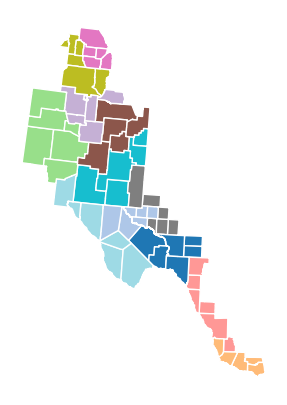

In [52]:
get_regionalization_maxp(
    threshold=5, 
    attrs_name=['density'], 
    threshold_name='count', 
    input_file_path='data/farms_us.shp', 
    plot_results=True)

## Defining the RegionDefiner: A Conversational Agent Built Upon OpenAI Assistant

The RegionDefiner is a conversational agent created to facilitate regional analysis and planning. It harnesses the power of the OpenAI Assistant, a state-of-the-art AI platform, to offer an intelligent, interactive experience in the domain of regionalization. The RegionDefiner is specifically designed to streamline the processing and analysis of spatial data, making sophisticated regional planning accessible to a wide range of users.

**Before proceeding the below scripts, please upload our given regionalization documents into the `documents` folder under the current working directory to achieve document retrieval.** The documents we provided include "max_p_region_algorithm.docx," "p_regions_problem.docx," "max_p.docx," "skater_algorithm.docx," "azp_algorithm.docx," and "spenc_algorithm.docx". Uploading these documents into the `documents` folder allows the RegionDefiner to effectively utilize the File Search feature of the OpenAI Assistant when addressing user inquiries.

In [53]:
class AssistantManager:
    def __init__(self, model=MODEL, verbose=False):
        self.client = OpenAI(api_key=OPENAI_API_KEY)
        self.model = model
        self.assistant = None
        self.thread = None
        self.run = None
        self.verbose = verbose                

    def create_assistant(self, name, instructions, tools):            
        self.assistant = self.client.beta.assistants.create(
            name=name,
            instructions=instructions,
            tools=tools,
            model=self.model,
            temperature=0
        )
    
    def update_assistant_by_adding_file_search_documents(self, file_paths):
        # Create a vector store for saving documents
        vector_store = self.client.beta.vector_stores.create(name="Regionalization Documents")

        # Ready the files for upload to OpenAI
        file_streams = [open(path, "rb") for path in file_paths]

        # Use the upload and poll SDK helper to upload the files, add them to the vector store,
        # and poll the status of the file batch for completion.
        file_batch = self.client.beta.vector_stores.file_batches.upload_and_poll(
          vector_store_id=vector_store.id, files=file_streams
        )

        self.assistant = self.client.beta.assistants.update(
          assistant_id=self.assistant.id,
          tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
        )

    def update_assistant_by_adding_shape_file_for_code_interpreter(self, shp_file_paths):
        
        file_ids = []
        for shp_file_path in shp_file_paths:
            file = self.client.files.create(
                file=open(shp_file_path, "rb"),
                purpose="assistants"
            )
            file_ids.append(file.id)

        self.assistant = self.client.beta.assistants.update(
            assistant_id=self.assistant.id,
            tool_resources={"code_interpreter": {"file_ids": file_ids}},
        )
        
    def create_thread(self):
        self.thread = self.client.beta.threads.create()

    def add_message_to_thread(self, role, content):
        self.client.beta.threads.messages.create(
            thread_id=self.thread.id,
            role=role,
            content=content
        )

    def run_assistant(self):
        self.run = self.client.beta.threads.runs.create(
            thread_id=self.thread.id,
            assistant_id=self.assistant.id
        )

    def wait_for_completion(self):
        previous_timestamp = datetime.datetime.now()  # Initial timestamp
        while True:
            time.sleep(1)
            run_status = self.client.beta.threads.runs.retrieve(
                thread_id=self.thread.id,
                run_id=self.run.id
            )
            if self.verbose:
                print(run_status.model_dump_json(indent=4))

            if run_status.status == 'completed':
                self.process_messages()
                elapsed_time = (datetime.datetime.now() - previous_timestamp).total_seconds()
                print(f"Elapsed time: {elapsed_time} seconds")
                break
            elif run_status.status == 'requires_action':
                if self.verbose:
                    print("Function Calling ...")
                    elapsed_time = (datetime.datetime.now() - previous_timestamp).total_seconds()
                    print(f"Elapsed time: {elapsed_time} seconds")
                self.call_required_functions(run_status.required_action.submit_tool_outputs.model_dump())
            elif self.verbose:
                print("Waiting for the Assistant to process...")
                elapsed_time = (datetime.datetime.now() - previous_timestamp).total_seconds()
                print(f"Elapsed time: {elapsed_time} seconds")

    def process_messages(self):
        messages = self.client.beta.threads.messages.list(thread_id=self.thread.id)     
        last_message = messages.data[0]
        role = last_message.role
        content = last_message.content[0].text.value
        print(f"{role.capitalize()}: {content}")    

    def call_required_functions(self, required_actions):
        previous_timestamp = datetime.datetime.now()  # Initial timestamp
        tool_outputs = []

        for action in required_actions["tool_calls"]:
            func_name = action['function']['name']
            arguments = json.loads(action['function']['arguments'])
            
            if func_name == "get_maxp_response":
                output = get_maxp_response(
                    threshold=arguments['threshold'], 
                    threshold_name=arguments['threshold_name'], 
                    attrs_name=arguments['attrs_name'], 
                    input_file_path=arguments['input_file_path'],
                    plot_results=arguments['plot_results'])
                tool_outputs.append({
                    "tool_call_id": action['id'],
                    "output": output
                })
            elif func_name == "get_p_regions_response":
                output = get_p_regions_response(
                    n_clusters=arguments['n_clusters'], 
                    attrs_name=arguments['attrs_name'], 
                    input_file_path=arguments['input_file_path'],
                    plot_results=arguments['plot_results'])
                tool_outputs.append({
                    "tool_call_id": action['id'],
                    "output": output
                })
            else:
                raise ValueError(f"Unknown function: {func_name}")
                
        if self.verbose:
            print("Submitting outputs back to the Assistant...")
            elapsed_time = (datetime.datetime.now() - previous_timestamp).total_seconds()
            print(f"Elapsed time: {elapsed_time} seconds")
        self.client.beta.threads.runs.submit_tool_outputs(
            thread_id=self.thread.id,
            run_id=self.run.id,
            tool_outputs=tool_outputs
        )


In [54]:
INSTRUCTION_PROMPT = """

As a Regionalization Expert Virtual Assistant, you specialize in regionalization tasks using specific documents, tools, and definitions. Construct your responses as follows:

1. Identify Inquiry Type:
   - Non-Regionalization Topics: Inform users that your focus is on regionalization and you do not handle unrelated topics such as facility location, resource allocation, route planning, site selection, and urban planning, etc.
   - Regionalization Queries:
     - General Questions: Use provided documents to share principles and methods related to regionalization.
     - Specific Analysis: Execute analyses using designated tools:
       - Max-p Problems: Conduct analyses on region count or allocation using 'get_maxp_response' tool tailored for Max-P region problems, considering specified thresholds.
       - P-Region Problems: Designate regions using 'get_p_regions_response' tool equipped with algorithms like Skater, AZP, Regional K-means, Spenc, Ward, and Random Region.

2. Conduct Specific Analyses:
   - Outline Workflow: First, outline the workflow to address the query, ensuring understanding of the problem and identifying the most suitable analytical tool.
   - Apply Tool: Precisely apply the appropriate tool, requesting more information if needed for clarity.

3. Offer General Informational Support:
   - Utilize Documents: For broader questions, use the provided documents to offer clear and concise insights into regionalization.

Foundational Knowledge:
- Regionalization Overview: Aggregating smaller areas into larger, contiguous, and homogeneous regions, optimizing for internal homogeneity and external heterogeneity under geospatial constraints. Application examples include spatial unit identification, zonal object design, etc.
- Max-P Region Problem: Clusters areas into the maximum number of regions where a specific attribute exceeds a threshold.
- P-Region Problem Algorithms:
    - Skater: Groups areas into contiguous, homogeneous regions based on a connectivity graph.
    - AZP: Forms regions maximizing internal homogeneity.
    - Regional K-Means: Clusters areas based on attribute similarities with spatial contiguity constraints.
    - Spenc: Ideal for non-convex clusters using graph cuts weighted by spatial proximity.
    - Ward: Merges areas into clusters based on minimum variance with spatial connectivity.
    - Random Region: Randomly groups areas into regions for comparative analysis.

Response Output Guidelines:
- Clarity: Use simple language and define technical terms clearly. Break complex concepts into understandable parts.
- Relevance: Ensure responses directly address the user's questions or explain how the information provided relates to their inquiry.
- Expert Guidance: For complex issues beyond the assistant's scope, recommend contacting SPOPT developers.
- Conciseness: Ensure responses are concise, clear, and directly relevant to the user’s inquiry.

"""

In [55]:
def create_regionalization_assistant(verbose):
    manager = AssistantManager(verbose=verbose)
    
    # Create assistant with regionalization tools
    manager.create_assistant(
        name="Regionalization Assistant",
        instructions=INSTRUCTION_PROMPT,
        tools=[
            {
                "type": "function",
                "function": {
                    "name": "get_maxp_response",
                    "description": "Cluster a set of geographic areas into the maximum number of homogeneous and spatially contiguous regions such that the value of a spatially extensive regional attribute is above a predefined threshold",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "threshold": {
                                "type": "integer",
                                "description": "The predefined threshold value required for each region."
                            },
                            "threshold_name": {
                                "type": "string",
                                "description": "Attribute name used for thresholding. The name of the spatially extensive attribute variable."
                            },
                            "attrs_name": {
                                "type": "array",
                                "items": {
                                    "type": "string"
                                },
                                "description": "The variables(attributes) in the data frame (attributes table) that will be used to measure regional homogeneity."
                            },
                            "input_file_path": {
                                "type": "string",
                                "description": "Directory for loading shapefile. It should end with '.shp'. E.g., 'mexicojoin.shp', 'airbnb_Chicago 2015.shp', etc. \
                                This must be explicitly provided by the user. DO NOT Infer a file path, and it is not the file already uploaded. \
                                The user's shapefile is already in the current folder, so input_file_path should not start with '/' or sth like '/mnt/data/'."                           
                            },
                            "plot_results": {
                                "type": "boolean",
                                "description": "Set to True to visualize the regionalization results unless user specifies."
                            },
                        },
                        "required": ["threshold", "threshold_name", "attrs_name", "input_file_path", "plot_results"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "get_p_regions_response",
                    "description": "Group spatial units into contiguous regions. Determine spatially contiguous regions based on the predefined number of regions and attributes to measure regional homogeneity.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "n_clusters": {
                                "type": "integer",
                                "description": "The desired number of contiguous regions into which spatial units are aggregated."
                            },
                            "attrs_name": {
                                "type": "array",
                                "items": {
                                    "type": "string"
                                },
                                "description": "The variables(attributes) in the data frame (attributes table) that will be used to measure regional homogeneity."
                            },
                            "input_file_path": {
                                "type": "string",
                                "description": "Directory for loading shapefile. It should be ending by '.shp'. E.g., 'mexicojoin.shp', 'airbnb_Chicago 2015.shp', etc. \
                                                This is must be explicitly provided by user. DO NOT Infer a file path, and it is not the file already uploaded. \
                                                User's shapefile is already in current folder, so input_file_path should not start with '/' or sth like '/mnt/data/'."
                            },
                            "algorithm": {
                                "type": "string",
                                "description": "The selected p-region algorithm, which should be one of the followings: 'skater', 'azp', 'kmeans', 'spenc', 'ward_spatial', 'random'."
                            },
                            "plot_results": {
                                "type": "boolean",
                                "description": "Set to True to visualize the regionalization results unless user specifies."
                            },
                        },
                        "required": ["n_clusters", "attrs_name", "input_file_path", "algorithm", "plot_results"]
                    }
                }
            },
            {"type": "file_search"},
            {"type": "code_interpreter"}
        ],
    )
    
    # Update Assistant by providing file search documents
    manager.update_assistant_by_adding_file_search_documents(
        file_paths=["documents/max_p.docx", "documents/p_regions_problem.docx", "documents/max_p_region_algorithm.docx", "documents/skater_algorithm.docx", "documents/azp_algorithm.docx", "documents/spenc_algorithm.docx"])
    
#    # Update Assistant by uploading shapefile
#    manager.update_assistant_by_adding_shape_file_for_code_interpreter(
#        shp_file_paths=["data/farms_us.shp"]
#    )
    
    # Initialize processing thread
    manager.create_thread()
    return manager


In [56]:
def conversations(user_message, manager=None, verbose=False):
    if manager is None:
        manager = create_regionalization_assistant(verbose=verbose)
        
    # add user_message
    manager.add_message_to_thread(
        role="user", 
        content=user_message)

    # run assistant
    manager.run_assistant()
    # final
    manager.wait_for_completion()

## Case Study Sessions: Practical Applications of the RegionDefiner

In this section of the notebook, we explore several case studies that illustrate the practical application and effectiveness of the RegionDefiner in addressing real-world regionalization challenges. These case studies demonstrate how the tool can be used to analyze spatial data, apply sophisticated algorithms, and generate actionable insights for regional planning and development.


## Case Study 1: Evaluating RegionDefiner's Responsiveness to Educational Content

### Overview
This case study aims to test the RegionDefiner's ability to accurately handle and respond to a range of educational queries. The focus will be on assessing its proficiency in discerning and responding appropriately to content that is directly related to regionalization as well as content that is completely unrelated.

### Objectives
- **Content Relevance:** Test the RegionDefiner’s effectiveness in identifying and responding to content specifically related to regionalization.
- **Handling Irrelevance:** Evaluate how the RegionDefiner manages questions that fall outside the scope of regionalization, focusing on its strategies for maintaining relevance or gracefully redirecting the user.
- **Educational Quality:** Assess the quality of responses in terms of educational value, accuracy, and the ability to engage the user.


In [196]:
#### Case Study 1 #### 
## intent detection
## general educational content
#VERBOSE = True
VERBOSE = False

manager = create_regionalization_assistant(verbose=VERBOSE)

In [197]:
conversations(
    user_message="We want to set aside appropriate amount and types of habitats to protect species from becoming extinct. Where should we place them? How to connect these selected habitats?", 
    manager=manager, 
    verbose=VERBOSE)

Assistant: Identify Inquiry Type: Non-Regionalization Topics

Your question involves aspects of conservation planning, including habitat selection and connectivity, which are crucial for biodiversity preservation. However, these topics fall outside my specialization in regionalization, which focuses on aggregating smaller areas into larger, contiguous, and homogeneous regions based on specific criteria and constraints. My expertise is more aligned with tasks such as spatial unit identification and zonal object design, rather than specific conservation strategies like habitat placement and connectivity.

For guidance on habitat selection and connectivity, I recommend consulting with experts in conservation biology, ecology, or environmental planning. These professionals can provide insights based on ecological principles, species-specific needs, and landscape connectivity analysis to ensure effective conservation outcomes.
Elapsed time: 5.807402 seconds


In [198]:
conversations(
    user_message="What is regionalization problem?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Identify Inquiry Type: General Questions

The regionalization problem involves the process of aggregating smaller geographic areas into larger, contiguous, and homogeneous regions. This process is guided by specific criteria and constraints with the aim of optimizing certain objectives. The primary goal is to ensure that the resulting regions are internally homogeneous in terms of certain attributes (e.g., demographic, economic, environmental characteristics) while being distinct from each other. This is achieved under the constraint of spatial contiguity, meaning that areas within a region must be geographically adjacent to each other.

There are two main types of regionalization problems:

1. **Max-P Region Problem**: This involves clustering areas into the maximum number of regions where a specific attribute or set of attributes exceeds a predefined threshold. The objective is to create as many regions as possible, each meeting or surpassing a certain criterion, while ens

In [199]:
conversations(
    user_message="Is it the same as clustering?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Identify Inquiry Type: General Questions

Regionalization and clustering are related but distinct concepts, each with its own objectives and methodologies. Here's a breakdown of the differences and similarities:

### Clustering:
- **Objective**: Clustering aims to group a set of objects (which can be anything from data points to geographic areas) in such a way that objects in the same group (called a cluster) are more similar to each other than to those in other groups. The primary focus is on the similarity of attributes, regardless of spatial proximity.
- **Spatial Consideration**: Traditional clustering algorithms (like k-means, hierarchical clustering) do not necessarily consider spatial contiguity. That is, the resulting clusters may not be geographically contiguous.
- **Applications**: Clustering is widely used in data analysis to identify patterns or groups within datasets, such as customer segmentation, image recognition, and anomaly detection.

### Regionalization:


## Case Study 2: Practical Regionalization with Mexico Data

This case study focuses on applying the RegionDefiner to solve a practical regionalization problem using spatial data from Mexico. The session aims to showcase how the RegionDefiner utilizes advanced algorithms and tools to perform effective spatial analysis and region delineation based on specific criteria.

In [200]:
### Case Study 2 ###
## solve p-region problem
#VERBOSE = True
VERBOSE = False

manager = create_regionalization_assistant(verbose=VERBOSE)

In [201]:
conversations(
    user_message="I want to delineate several groups of states to analyze regional development in Mexico.", 
    manager=manager, 
    verbose=VERBOSE
)

Assistant: Identify Inquiry Type: Regionalization Queries - Specific Analysis

To assist you with delineating groups of states for analyzing regional development in Mexico, I will need to conduct a specific analysis. Before proceeding, could you please provide more details on the following:

1. **Number of Regions**: How many groups or regions do you want to delineate?
2. **Attributes for Homogeneity**: What attributes or variables do you want to use to measure the homogeneity within these regions? (e.g., GDP, population density, education level)
3. **Shapefile**: Confirm if you have uploaded the shapefile for Mexico that includes the states and any relevant attributes.
4. **Preferred Algorithm**: Do you have a preference for the regionalization algorithm? (e.g., Skater, AZP, Regional K-means, Spenc, Ward)

This information will help outline the workflow and select the most suitable analytical tool for your query.
Elapsed time: 8.099505 seconds


In [202]:
conversations(
    user_message="I want to create five groups and show me visualization result.",
    manager=manager,
    verbose=VERBOSE
)

Assistant: Identify Inquiry Type: Regionalization Queries - Specific Analysis

To proceed with creating five groups of states in Mexico for analyzing regional development and to provide a visualization of the results, I will need a bit more information:

1. **Attributes for Homogeneity**: Could you specify the attributes or variables you wish to use to measure the homogeneity within these regions? This is crucial for ensuring the regions are meaningfully delineated based on your analysis goals.
2. **Shapefile Confirmation**: Please confirm if the shapefile you've uploaded includes the states of Mexico and the necessary attributes for this analysis.
3. **Preferred Algorithm**: If you have a preference for the regionalization algorithm (e.g., Skater, AZP, Regional K-means, Spenc, Ward), please let me know. If not, I can select the most suitable one based on the attributes you're interested in analyzing.

Once I have this information, I can outline the workflow and apply the appropriate t

In [203]:
conversations(
    user_message="Can I set the state name as an attribute describing regional homogeneity? The shapefile has been uploaded in 'mexicojoin.shp' file path.", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Identify Inquiry Type: Regionalization Queries - General Questions

Using the state name as an attribute for describing regional homogeneity in a regionalization analysis is not typical. Regional homogeneity usually refers to quantitative or qualitative attributes that can vary across different locations, such as economic indicators (e.g., GDP, unemployment rate), demographic characteristics (e.g., population density, education levels), or other measurable factors that can be used to assess similarity or dissimilarity among regions.

The state name, being a nominal variable with unique values for each state, does not inherently provide a measure of similarity or dissimilarity that can be used for clustering or regionalization purposes. Instead, regionalization aims to group areas based on shared characteristics or attributes that reflect the regions' internal homogeneity and external heterogeneity.

For your analysis of regional development in Mexico, it would be more approp

In [204]:
conversations(
    user_message="Alright, I'd like to use GDP data from 1980–1990 as the attributes. In addition, Can you explain how the various algorithms would handle this differently?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Identify Inquiry Type: Regionalization Queries - General Questions

Using GDP data from 1980–1990 as attributes for regional homogeneity is a suitable choice for analyzing regional development in Mexico. This will allow you to group states based on economic performance over that decade, providing insights into regional development patterns.

Here's a brief overview of how different regionalization algorithms would handle this analysis differently:

1. **Skater**: The Skater algorithm groups areas into contiguous, homogeneous regions based on a connectivity graph. It prioritizes spatial contiguity and aims to minimize the variance within regions while considering the GDP data. Skater would be suitable if you're looking for regions that are not only similar in terms of GDP but also geographically adjacent.

2. **AZP (Automatic Zoning Procedure)**: AZP also forms regions maximizing internal homogeneity based on the attributes (GDP data in your case) while ensuring regions are s

Assistant: The regionalization process using the Skater algorithm with the corrected attributes `PCGDP1980` and `PCGDP1990` was successful. We have successfully delineated Mexico into five unique regions based on the economic performance data from the 1980s and 1990s. These regions are designed to be internally homogeneous in terms of GDP per capita growth over the specified period, while also being spatially contiguous.

The results have been saved in the 'mexicojoin_output.shp' file, with the regions indicated in the 'region' column. This file now contains the delineated groups of states in Mexico, organized to analyze regional development based on historical GDP data.

If you need further analysis or have additional questions, feel free to ask!
Elapsed time: 21.408459 seconds


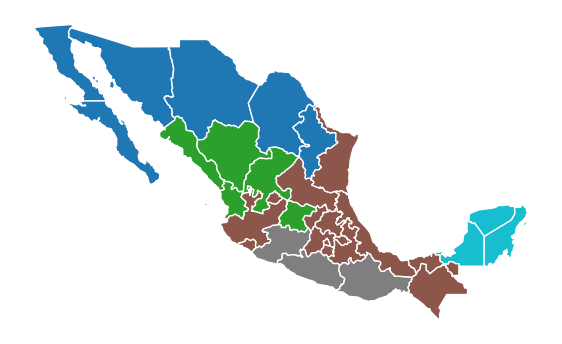

In [205]:
conversations(
    user_message="Cool, let's try Skater for this problem.",
    manager=manager,
    verbose=VERBOSE
)

## Case Study 3: Solving a Max-P Problem with Local Data

This case study demonstrates the RegionDefiner's ability to handle and solve a Max-P Problem using spatial data directly stored in a local device. The task will illustrate how the tool can effectively use local data sources to perform complex regional analysis and delineation, enhancing local planning and decision-making.

**Before proceeding, please ensure that "farm_us.shp" and all necessary related shapefiles are uploaded to the `data` folder within the current working directory.**


In [15]:
### Case Study 3 ###
## solve p-region problem for US Farm problem
#VERBOSE = True
VERBOSE = False

manager = create_regionalization_assistant(verbose=VERBOSE)

In [16]:
conversations(
    user_message="I aim to maximize the number of clusters for regions to perform a detailed analysis of regional development patterns in U.S. agriculture.", 
    manager=manager, 
    verbose=VERBOSE
)

Assistant: Identify Inquiry Type: Specific Analysis

To assist with your goal of maximizing the number of clusters for regions to analyze regional development patterns in U.S. agriculture, we will use the Max-P region problem approach. This method is designed to cluster geographic areas into the maximum number of homogeneous and spatially contiguous regions, ensuring that the value of a spatially extensive regional attribute is above a predefined threshold. This approach is particularly useful for detailed analysis in fields such as agriculture, where understanding localized patterns can inform better decision-making and policy development.

### Workflow Outline:
1. **Define the Threshold**: Identify the specific threshold value that each region must meet. This could be related to agricultural output, land use intensity, or any other relevant metric.
2. **Select Attributes for Homogeneity**: Choose the variables that will be used to measure regional homogeneity. These could include fac

data/farms_us.shp is not a file in any installed dataset.
Shapefile not found in libpysal examples. Attempting to read from a local path.
Assistant: The analysis to maximize the number of clusters for regions, focusing on the 'density' attribute with a threshold value of 0.1, has been successfully completed. The process resulted in **19 regions** being identified within the U.S. agriculture dataset. This regionalization will allow for a detailed analysis of regional development patterns, providing insights into how density affects agricultural practices and outcomes across different areas.

The updated geographic data, including the newly formed regions, has been saved in the shapefile named `data/farms_us_output.shp`. This file can be used for further analysis or visualization to understand the specific characteristics and development patterns of each region.

If you need further analysis or have additional questions, feel free to ask!
Elapsed time: 74.741236 seconds


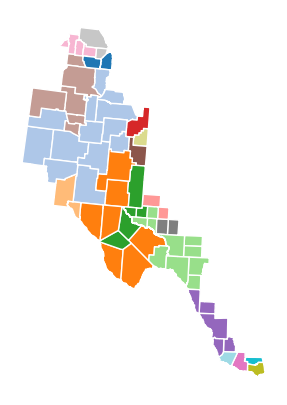

In [17]:
conversations(
    user_message="I have uploaded shapefile naming 'data/farms_us.shp'. Let's focus on density attribute, and please set threshold value to 0.1 since the 'density' value range is below 1.",
    manager=manager,
    verbose=VERBOSE
)

## Case Study 4: Query Domain Identification with RegionDefiner

This case study tests the RegionDefiner's capability to discern whether user-submitted queries pertain to the domain of regionalization. By providing a set of diverse queries, we will evaluate the tool's understanding and classification accuracy, highlighting its ability to correctly recognize and respond to regionalization-related topics.

In [18]:
### Case Study 4 ###
### Regionalization Problem Recognition
VERBOSE = False

manager = create_regionalization_assistant(verbose=VERBOSE)

In [19]:
conversations(
    user_message="I will ask you 10 questions, please tell me whether each question is a Regionalization-related issue. Give me a short answer first (yes/no), then your logic reasoning", 
    manager=manager, 
    verbose=VERBOSE
)

Assistant: Sure, please go ahead and ask your questions.
Elapsed time: 3.629941 seconds


In [20]:
conversations(
    user_message="1.How to divide the contiguous United States into four major climate zones, considering variations in temperature and precipitation?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Yes.

This question pertains to regionalization because it involves aggregating smaller areas (in this case, parts of the contiguous United States) into larger, contiguous, and homogeneous regions based on specific attributes (temperature and precipitation variations). The goal is to optimize for internal homogeneity within each climate zone regarding these attributes, which aligns with the principles of regionalization.
Elapsed time: 5.09034 seconds


In [21]:
conversations(
    user_message="2.How to identify the most appropriate spatial unit to delineate neighborhood in urban social science research?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Yes.

This question is related to regionalization as it involves identifying or aggregating spatial units into larger, contiguous regions that are homogeneous in terms of certain social science criteria. The process of delineating neighborhoods for urban social science research requires considering the internal homogeneity of social, economic, or physical characteristics, which is a core aspect of regionalization.
Elapsed time: 4.719935 seconds


In [22]:
conversations(
    user_message="3.I want to define ecological areas in the contiguous United States and want to see how the areas identified by algorithms compared to ecoregions defined by experts.", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Yes.

This inquiry is relevant to regionalization because it involves the process of defining ecological areas (regions) based on specific criteria or attributes, such as climate, soil types, vegetation, and other ecological factors. The comparison of algorithmically identified areas to expert-defined ecoregions also falls within the scope of regionalization, as it assesses the effectiveness of regionalization algorithms in capturing the homogeneity and contiguity of ecological characteristics that experts consider.
Elapsed time: 4.752194 seconds


In [23]:
conversations(
    user_message="4.I would like to explicitly design zonal objects as meaningful entities related to a certain goal. For example, I’d like to decide which kind of areal objects would be most useful for studying housing characteristics or unemployment rates. ", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Yes.

This question is related to regionalization because it involves designing zonal objects, or regions, based on specific goals or attributes such as housing characteristics or unemployment rates. The process of deciding on the most useful areal objects for studying these attributes requires aggregating spatial units into larger, contiguous, and homogeneous regions that are meaningful for the research objective, which is a fundamental aspect of regionalization.
Elapsed time: 3.593573 seconds


In [24]:
conversations(
    user_message="5.I intend to aggregate 4000 transportation analysis zones from six counties in Southern California, USA, into around 100 model zones, the maximal number considered viable for an urban economic model. What should I do? ", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: Yes.

This question directly relates to regionalization as it involves the aggregation of smaller spatial units (transportation analysis zones) into a smaller number of larger, contiguous, and homogeneous regions (model zones) for the purpose of urban economic modeling. The goal is to optimize the internal homogeneity of these model zones while considering spatial contiguity, which is a core principle of regionalization. The process described aims to simplify the spatial framework for the model while maintaining meaningful economic and transportation characteristics.
Elapsed time: 4.951342 seconds


In [25]:
conversations(
    user_message="6.The Tennessee Valley Authority (TVA) operates several coals fueled power plants in the Tennessee Valley region. How to determine the largest amount of additional generation capacity that can be added to existing power plant sites? ", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: No.

This question is focused on determining the capacity for expansion of existing facilities, specifically the generation capacity of coal-fueled power plants operated by the Tennessee Valley Authority. It involves facility capacity analysis rather than the aggregation of areas into regions based on homogeneity or contiguity, which is the essence of regionalization. This inquiry is more related to facility location and capacity planning rather than regionalization.
Elapsed time: 4.574638 seconds


In [26]:
conversations(
    user_message="7.Tomorrow, a tornado is predicted to move across Oklahoma City, from southwest to northeast. Where should I park the mobile radar vehicle for meteorological observation so that I may acquire high-quality data?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: No.

This question pertains to the strategic placement of a mobile radar vehicle for optimal data collection during a specific meteorological event, rather than the aggregation of areas into larger, contiguous, and homogeneous regions based on certain attributes. It is more related to site selection and operational planning in response to a short-term event, rather than the principles of regionalization.
Elapsed time: 3.529085 seconds


In [27]:
conversations(
    user_message="8. Drones are dispatched with valuable and time-sensitive medical supplies to respond to emergency cases. To optimize the drone emergency delivery system, which stations should be selected to equip the drones? Which drone should serve which patient?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: No.

This question deals with optimizing a drone emergency delivery system, focusing on station selection for drone equipment and assignment of drones to specific patients. It involves logistics, resource allocation, and route planning to ensure efficient and timely delivery of medical supplies. This does not relate to regionalization, which is about aggregating spatial units into larger, contiguous, and homogeneous regions based on specific attributes.
Elapsed time: 3.528163 seconds


In [28]:
conversations(
    user_message="9. We drive from different work locations and would like to find an intermediate meetup location to hand over important documents. Where is the ideal meet-up location? How to route people?", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: No.

This question is focused on identifying an optimal meet-up location and routing for individuals coming from different work locations, which pertains to location optimization and route planning. It does not involve the aggregation of areas into larger, contiguous, and homogeneous regions based on specific attributes, which is the core of regionalization. This inquiry is more related to logistics and spatial decision-making for individual movements rather than regionalization principles.
Elapsed time: 4.68012 seconds


In [29]:
conversations(
    user_message="10.City of Phoenix is the capital of the state of Arizona. It has a subtropical desert climate with particularly hot summers and mild winters. I want to identify suitable areas for the new green space.", 
    manager=manager,
    verbose=VERBOSE
)

Assistant: No.

This question involves identifying specific areas within a city suitable for creating new green spaces, based on climate and possibly other environmental or urban planning criteria. While it may involve considerations of spatial characteristics, it is more aligned with urban planning and site selection for specific land use rather than the aggregation of areas into larger, contiguous, and homogeneous regions, which is the essence of regionalization.
Elapsed time: 5.901639 seconds
